# Hexagon grid by city

Create an H3 hexagon grid by metropolitan area at resolutions 8, 9, 10 and 11, identifying urban and rural areas.

## Import libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-11-07 17:18:01 Configured OSMnx 1.1.2
2023-11-07 17:18:01 HTTP response caching is on


## Download data

### Donwloand cities names for analysis

In [2]:
schema = 'metropolis'
table = 'metro_gdf_2020'

query = f"SELECT DISTINCT city from {schema}.{table}"

city_names = aup.df_from_query(query)
print(city_names.shape)
city_names.head(4)

(71, 1)


,city
0,Villahermosa
1,Matamoros
2,Chetumal
3,Cordoba


## Download mun_gdf

In [3]:
schema = 'metropolis'
table = 'metro_gdf_2020'

city = 'Guadalajara'

query = f"SELECT * FROM {schema}.{table} WHERE \"city\" = \'{city}\'"

mun_gdf = aup.gdf_from_query(query)
print(mun_gdf.shape)
mun_gdf.head(2)

(7, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara
1,14051,14,051,Juanacatlán,"POLYGON ((-103.13701 20.57179, -103.13028 20.5...",Guadalajara


### Download AGEB data

In [4]:
schema = 'censoageb'
table = 'censoageb_2020'

ageb_gdf = gpd.GeoDataFrame()

for cvegeo in mun_gdf.CVEGEO.unique():
    query = f"SELECT cve_geo,pobtot,geometry FROM {schema}.{table} WHERE \"cve_geo\" LIKE \'{cvegeo}%%\'"
    ageb_gdf = pd.concat([ageb_gdf, aup.gdf_from_query(query)],
                        ignore_index = True, axis = 0)
print(ageb_gdf.shape)
ageb_gdf.head(4)

(1954, 3)


,cve_geo,pobtot,geometry
0,1403900012696,6406,"POLYGON ((-103.37645 20.63875, -103.37680 20.6..."
1,1403900014207,4817,"POLYGON ((-103.27836 20.69867, -103.27858 20.6..."
2,1403900013020,4278,"POLYGON ((-103.31307 20.72129, -103.31271 20.7..."
3,1403900014194,3732,"POLYGON ((-103.27806 20.69903, -103.27947 20.6..."


## Create hexgrid

In [5]:
hex_gdf = aup.create_hexgrid(mun_gdf, 8)
print(hex_gdf.shape)
hex_gdf.head(4)

(2857, 2)


,hex_id_8,geometry
0,88498c9697fffff,"POLYGON ((-103.39405 20.69854, -103.38951 20.7..."
1,88498c95d3fffff,"POLYGON ((-103.31071 20.73802, -103.30617 20.7..."
2,88498c9463fffff,"POLYGON ((-103.29464 20.67659, -103.29010 20.6..."
3,88498c96e5fffff,"POLYGON ((-103.34671 20.66373, -103.34218 20.6..."


<AxesSubplot: >

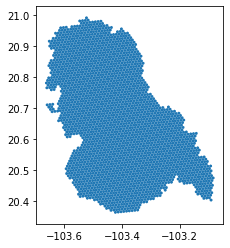

In [6]:
hex_gdf.plot()

## Spatial join

### Centroid to municipality

In [7]:
hex_cnt = gpd.GeoDataFrame(geometry=hex_gdf.representative_point(), crs="EPSG:4326")
hex_cnt = hex_cnt.merge(hex_gdf[['hex_id_8']],  left_index=True, right_index=True)
print(hex_cnt.shape)
hex_cnt.head(2)

(2857, 2)


,geometry,hex_id_8
0,POINT (-103.39459 20.70373),88498c9697fffff
1,POINT (-103.31125 20.74321),88498c95d3fffff


Test merge

<AxesSubplot: >

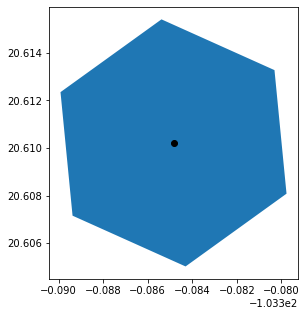

In [8]:
fig,ax = plt.subplots(figsize=(5,5))
hex_gdf.loc[hex_gdf.hex_id_8=='8849ab5961fffff'].plot(ax=ax)
hex_cnt.loc[hex_cnt.hex_id_8=='8849ab5961fffff'].plot(color='black',ax=ax)


Intersection

In [9]:
cnt_join = hex_cnt.sjoin(mun_gdf).drop(columns='index_right')
print(cnt_join.shape)
cnt_join.head(4)

(2857, 7)


,geometry,hex_id_8,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,city
0,POINT (-103.39459 20.70373),88498c9697fffff,14039,14,039,Guadalajara,Guadalajara
1,POINT (-103.31125 20.74321),88498c95d3fffff,14039,14,039,Guadalajara,Guadalajara
2,POINT (-103.29517 20.68178),88498c9463fffff,14039,14,039,Guadalajara,Guadalajara
3,POINT (-103.34725 20.66892),88498c96e5fffff,14039,14,039,Guadalajara,Guadalajara


Centroid to polygon join

In [10]:
hex_merge = hex_gdf.merge(cnt_join[['hex_id_8','CVEGEO','NOMGEO','city']],
             on='hex_id_8')
print(hex_merge.shape)
hex_merge.head(4)

(2857, 5)


,hex_id_8,geometry,CVEGEO,NOMGEO,city
0,88498c9697fffff,"POLYGON ((-103.39405 20.69854, -103.38951 20.7...",14039,Guadalajara,Guadalajara
1,88498c95d3fffff,"POLYGON ((-103.31071 20.73802, -103.30617 20.7...",14039,Guadalajara,Guadalajara
2,88498c9463fffff,"POLYGON ((-103.29464 20.67659, -103.29010 20.6...",14039,Guadalajara,Guadalajara
3,88498c96e5fffff,"POLYGON ((-103.34671 20.66373, -103.34218 20.6...",14039,Guadalajara,Guadalajara


### AGEB Intersection

In [11]:
ageb_join = ageb_gdf.sjoin(hex_merge).drop(columns='index_right')

Test

In [12]:
ageb_gdf.loc[ageb_gdf.cve_geo.isin(list(ageb_join.cve_geo.unique()))].pobtot.sum()

4997967

In [13]:
ageb_gdf.pobtot.sum()

4997967

In [14]:
ageb_gdf.shape

(1954, 3)

In [15]:
ageb_gdf.loc[ageb_gdf.cve_geo.isin(list(ageb_join.cve_geo.unique()))].shape

(1954, 3)

Define urban

In [18]:
hex_list = list(ageb_join.hex_id_8.unique())
hex_merge.loc[:,'type'] = 'rural'
hex_merge.loc[hex_merge.hex_id_8.isin(hex_list),'type'] = 'urban'
print(hex_merge.shape)
hex_merge.head(4)

(2857, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498c9697fffff,"POLYGON ((-103.39405 20.69854, -103.38951 20.7...",14039,Guadalajara,Guadalajara,urban
1,88498c95d3fffff,"POLYGON ((-103.31071 20.73802, -103.30617 20.7...",14039,Guadalajara,Guadalajara,urban
2,88498c9463fffff,"POLYGON ((-103.29464 20.67659, -103.29010 20.6...",14039,Guadalajara,Guadalajara,urban
3,88498c96e5fffff,"POLYGON ((-103.34671 20.66373, -103.34218 20.6...",14039,Guadalajara,Guadalajara,urban


<AxesSubplot: >

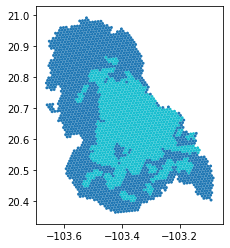

In [19]:
hex_merge.plot('type')